<h1>Math</h1>

In this notebook, we are going to look at one of the most recent and impactful breakthroughs in RNNs which is the idea of Attention

---

<h3>Attention Intro</h3>

So to start, we want to think back to some of the ideas we have been alluding to throughout the course

We started out by looking at two different ways of solving the many to one task


The first way was just to do what we have always been doing in the past

Pass the seqeunce through the RNN, and pass the final output to a dense layer to get a prediction conditioned on the entire input sequence

<img src='extras/36.1.PNG' width='350'></img>

This makes sense because we want our RNN to make a prediction affter considering the entire input sentence

It would be odd, to say the least, if we consistently read only half a sentence to determine its meaning

---

We know that while LSTMs and GRUs are capable of learning long-term dependencies they still have limitations, its a question of how long?

Maybe an LSTM is good for a sentence ot two, but what about 1000 sentences, probably not

Sometimes we want to look at a hidden state somewhere in the middle

So in that case we do a global maxpool over all the RNN states

<img src='extras/36.2.PNG' width='350'></img>

This is just like how we use maxpooling in an image classification

We are basically asking, where is the relevant feature

If we only take the final RNN state, then we can only hope that the RNN has not only found the relevant feature, but kept it all the way to the end

---

Another idea we alluded to earlier is that, we know that taking the max of something can be considered the "hardmax"

It means take the maximum and forget about everything else

But we know that deep learning is probabilistic and maybe we can use the softmax to give us a spread of probabilities for how much each hidden state matters

<img src='extras/36.3.PNG' width='300'></img>

This is the basic intuition behind Attention

In the next section, we are going to go over the actual calculations for how attention works

<h1>Math</h1>

So how does attention actually work ?

In this section we are going to look at the details and using these calculations it should give us some ideas of what the code would look like

The main theme of this lecture is that, everything is a neural network

Whats interesting about these recent topics is that, we always go to the review notebook (notebook 32)

So in the review notebook, we discussed how to think about GRUs and LSTMs (showing GRU below)

<img src='extras/36.4.PNG' width='600'></img>

The way to think about them is that they are a system inside a box

The system involves several mini-neural networks doing different things

<ul>
    <li>We have one neural network to predict the next hidden state
    </li>
    <li>That, depends on the output of several other neural networks</li>
    <li>Those neural networks predict how much to remember or forget past hidden states</li>
    <li>So everything is a neural network!</li>
</ul>

We are going to apply the same principle here

How do we predict which hidden state to pay attention to ?

We pass it through a neural network and thats going to tell us which one we should care about

---

<h3>Attention</h3>

So lets dive into the details

The first step is of course the encoder!

We are still building the Seq2Seq model and we are still going to work on the machine translation problem

So still doing Seq2Seq, still using same data from previous notebook, still going to have encoder and decoder, but just the way we build them is more advanced, so back to the encoder

Recall asking in the previous notebook, what happened to the Bi-directional RNNs ?

Well, here they make their return

So the encoder, is going to use a Bidirectional LSTM rather than just a regular LSTM

This is going to give us an entire sequence of hidden states, where of course the length is $T_x$

Bidirectional means we are reading the states both forward and backwards and passing those states on to the decoder

Also remember that, since there are two LSTMs within this unit, the output is going to be of size $T_x \times 2M$

This is why we did all these exercises earlier (notebook 34) where we really tried to pay attention to all the shapes

Its because this is going to be really important if we want to get through this notebook

Another thing thats important, is we are going to completely ignore the cell state of the Bidirectional LSTM in the encoder

Thats just thrown away, and we only make use of the $h$s

<img src='extras/36.5.PNG' width='600'></img>

---

<h3>Attention</h3>

Next we have the decoder side, which is responsible for taking the $h$s and producing the translation

The strategy we are going to take here, is we are going to start off with a really high level description and then step by step we are going to dig down into the details

So with just the high level explanation, we will still have some sense if whats going on, but we wont know enough to implement something like this ourselves nor even understand the code :(

But as we go deeper and deeper, the idea is we are going to slowly reveal more and more details so that we get to a point where we can actually understand the code :)

This is quite the complex topic, so its okay if we dont understand everything the first time

This is probably one of these times where we are not going to fully understand the concepts so we are going to look at the code, but then we wont undersstand the code either, so then we will go back to the concepts, so we will go back and forth in sort of an iterative way to validate each detail as we learn more and more

So thats the strategy we would take here

We wont try to learn it all at once, instead we will try to go from the high level down to the details, one step at a time

---

<h3>Attention vs Seq2Seq</h3>

The very first step is to remember what regular Seq2Seq does

Remember with Attention, we are still doing Seq2Seq, but now its a special kind of Seq2Seq, so it works differently from regular Seq2Seq

Regular Seq2Seq is like this, we take the last hidden state from the encoder and pass that in as the initial state to the LSTM

<img src='extras/36.6.PNG' width='300'></img>

And by the way to differentiate between the hidden state of the encoder and decoder, we are going to start calling the encoder's hidden states $h$ and the decoder's hidden states $s$

so with Regular Seq2Seq $h_{T_x} = s_0$

---

With Attention we have something different

The first thing to remember is that with Attention, we no longer care only about $h_{T_x}$, we care about all the $h$s

So all the $h$s are going to get fed into some kind of attention calculator

And this attention calculator is going to give us one final vector called the <strong>context</strong> which tells us which $h$ we care most about

<img src='extras/36.7.PNG' width='300'></img>

Now, because the $h$s are all getting passed into the bottom of the decoder LSTM, there is no longer to pass it through the side (to the left of the decoder), so through the side we just set $s_0=0$

When we are talking about Attention, its often more useful to draw the encoder at the bottom of the page and the decoder at the top of the page, rather than side by side

The reason is, we can think of the data from each of the hidden states of the encoder s flowing upwards into the decoder

---

<h3>Attention</h3>

Now lets make this a little more detailed

So at a very high level, we know that the decoder is going to be an LSTM

of course this one cant be bidirectional, since we can only generate one word at a time

So the decoder LSTM is jsut a regular LSTM

Now lets suppose we are at some arbitary step of the decoder LSTM and we want to predict the next word, what do we do

Well we know that the LSTM should have two arrows going in

one from the side that we get from the previous state

And one from the bottom, which because we are doing attention, now comes from the encoder's hidden states

But we know that the thing going into the bottom of the LSTM has to be a vector, which we have been calling the context vector

So how do we get this vector ?

Well this is where Attention comes into play

This vector is just the weighted average of all the hidden states form the decoder

the usual symbol we use for these weights is $\alpha$, and they tell us how important each hidden state is for producing this particular output word

These $\alpha$s are called Attention weights

<img src='extras/36.8.PNG'></img>

---

The next detail we want to look at is, how do we calculate those $\alpha$s ?

And as we mentioned earlier, we want to use a neural network

This makes the entire neural network end-to-end differentiable, so we can train the whole thing all at once

The entire system is just one humongous neural network containing several mini-neural networks

So for this particular mini-neural network, we are not even going to see any of the equations and we are doing this on purpose because it is already pretty complicated :)

So this is one of those rare opportunities where the equation is actually very non-trivial so we are going to go through each part in painstaking detail

$$\alpha_{t^\prime} = \text{NeuralNet}([s_{t-1},h_{t^\prime}]),t^\prime = 1 \ldots T_x$$

First, we will note that we have two different $t$s

We have $t$ and $t^\prime$, why ?

Well thats because we have two different sequences, the input sequence and the output sequence

For each step of the output sequence, we want to consider all steps of the input sequence

So right now we are looking at a single step of the output, over all hidden states from the input

so $t$ is telling us which output we are currently trying to calculate Attention for 

$t^\prime$ tells us, which $\alpha$ we are currently calculating

And how many $\alpha$s are there ?

Of course we have $T_x$ $\alpha$s because we also have $T_x$ hidden states

Remember that the $\alpha$ is jsut the weight for the state, to tell us how much we care about that state right now

And again, t is for the output seqeunce, $t=1\ldots T_y$

$t^\prime$ is for the input sequence $t^\prime=1\ldots T_x$

---

The next question is, why do we have this $s_{t-1}$ here ?

$$\alpha_{t^\prime} = \text{NeuralNet}([\boxed{s_{t-1}},h_{t^\prime}]),t^\prime = 1 \ldots T_x$$

Well we can imagine that the Attention weights depend on two things

They depend not only on the hidden states, but also where I am in the output sequence

In other words, if we just start generating the output, we are going to care about different $h$s than if we have almost finished generating the output

So we can imagine that if we did not condition on $s_{t-1}$ here, and the $\alpha$s depended only on the $h$s, then the Attention weights would just be the same for every step, which does not make any sense at all since in that case we would not need attention in the first place

So we need information from the $s$s, because that gives us the context of where we are at the output sequence

---

<h3>Concrete Example</h3>

Suppose we want to translate the sentence "How are you today?" into Arabic

English : $\color{red}{\text{How}}\color{green}{\text{ are you }}\color{blue}{\text{today?}}$

Arabic : $\color{red}{\text{كيف}}\color{green}{\text{ حالك }}\color{blue}{\text{اليوم؟}}$

ٍSo when generating the first word of the translation, our attention is currently on the first word "How"

When we are generating the second word in the translation, our attention is no longer on the English word "How", but has moved over to "are you"

So we can see that, which part of the input sequence we pay attention to must change as we generate new words in the output

So hopefully that helps us understand why the attention weights dont just depend on the $h$s but also the $s$s

---

<h3>Calculating attention weights</h3>

Alright, so now lets have a closer look at how to calculate the $\alpha$s, just to give ourselves a more concrete idea of how its going to be done in code

We know that the first step is to concatenate $s_{t-1}$ and $h(t^\prime)$ together

$$z = concat[s_{t-1},h_{t^\prime}]$$

we are running out of letters here, but suppose we call this concatenation $z$

note : we are only using the letter $z$ for this particular sub-section & and maybe a few others, but nowhere else will we use $z$ for the same purpose, so if we see another $z$ later on, dont get it confused

So once we have $z$, what do we do with it ?

Well ass promised, this is going to go through a regular feedforward neural netwrok

In the code we are going to use to dense layer, so thats what we are showing here

```
layer 1 of ANN
```
$$z = tanh(W_1z+b_1)$$

```
layer 2 of ANN
```
$$z = softmax(W_2z+b_2)$$

The last step is of course a ```softmax```, because this is going to give us a probability telling us how much to pay attention to each $h$

BUT WAIT

---

In these equations, we have only calcualted the output for one hidden state $h_t^\prime$

In order to properly do the ```softmax```, it needs to be over all the activations for all the hidden states from $t^\prime = 1 \ldots T_x$

This is becasue we want all the $\alpha$s to sum to 1

$$\sum^{T_x}_{t^\prime} \alpha(t^\prime)=1$$

Thats going to give us a proper weighted average, of the hidden states

---

So we cheated a little bit in the previous sub-section, because in fact, what we are actually going to do is calcualte the same thing for all $h_{t^\prime}$s all at the same time

This is required because the final softmax has to be over all $T_x$ of these values

So what we have to do is, pass each of the $h$s through the same neural network, get all those outputs and then we can calculate their softmax, which is kind of a special <strong>softmax over time</strong>

$$\alpha(t^\prime) = \frac{\exp(out(t^\prime))}{\sum\limits^{T_x}_{\tau \ = \ 1}\exp(out(\tau))}$$

---

<h3>Calculating attention weights</h3>

Now this might strike us as odd because we have $h_1,h_2,\ldots,h_{T_x}$, but we only have one $s_{t-1}$

In actuality, what we do is simply copy $s_{t-1}$ over to each $h$

That way each of them has a copy to concatenate with, and then we can pass each of those vectors through the same neural network and get their outputs

```
out(1) = NeuralNet([  s(t-1),  h(1)  ])
out(1) = NeuralNet([  s(t-1),  h(2)  ])
...
out(Tx) = NeuralNet([ s(t-1),  h(Tx)  ])
```

At the end we calculate the softmax over each of those outputs

```
alpha = softmax(out)
```

---

So this is why when we look at diagrams of attention, we are going to see $s_{t-1}$ getting copied over to each hidden state $h$

<img src='extras/36.9.PNG'></img>

As we can see, when we draw everything out, things get a little messy, but all the peices are here

so we can see that $s_{t-1}$, which comes from the upper left gets concatenated to each of the $h$s

Then those get passed through a neural network

Then those neural network outputs get softmaxed, that gives us the $\alpha$s

Those $\alpha$s get dotted with the $h$s to give us a weighted some of the $h$s

That gives us the context which gets passed into the bottom of the decoder LSTM

Now that we have both the bottom input, and the left side input, which is jsut $s_{t-1}$, we can calculate the next state $s_t$ and so on

---

<h3>Decoder</h3>

So now the hard part of Attention is done

whats left ?

Well we know have all these $\alpha$s, which are going to help us weight each of the encoder's hidden states and that can give us the context vector for each output step

we multiply each of the hidden states by its corresponding $\alpha$, and we assign this to a new vector called the context vector

once we have this, we know exactly what to feed into the decoder LSTM

<img src='extras/36.10.PNG'></img>

So on the left side, we have the previous hidden state

As we discussed, the initial value for that is just going to be 0

At the bottom we will just have the context vector, and so to calculate the output prediction we just do this $T_y$ times

ok, so on step 1 we have $s_0=0$, and then we pass in $\text{context(1)}$

At the next step, we have $s(1)$ and then we pass in to the bottom $\text{context(2)}$

And we do that over and over again until the last step where we pass in $\text{context(}T_y)$

---

<h3>Pseudocode</h3>

Some psudeocode should help us understand this better

```python
h = encoder(input) # grab hidden states from encoder given input sentence
s = 0 # initialise s into a bunch of zeros

for t in range(Ty):
    alphas = neural_net(s,h) # calculate attention weights given the previous s and all the hidden states form the encoder
    context = dot(alphas,h) # then we use that to calculate the context vector
    o,s = decoder_lstm(context,initial_state=s) # then we pass in this context vector into our decoder LSTM along with s as its previous state, from this we get an output and also a new s, which we will be using on the next round
    output_prediction = dense(o) # with this output, we can pass this through our final dense layer with the softmax  to get the current translated word, in other words this is almost like the decoding step from our previous Seq2Seq model and our poetry generator, except that now we are doing it in tems of symbolic variables rather than real numpy arrays
```
---

<h3>Summary</h3>

Since that was pretty long, in this sub-section we are going to summarise everything we discussed in this section

<img src='extras/36.11.PNG'></img>

At this point, now that we have seen all the details, it helps to go back to the high level picture where we compare regular Seq2Seq with this new Seq2Seq with Attention

So remember that with old Seq2Seq, the encoder's final hidden state $h_{T_x}$ gets passed in as the initial hidden state of the decoder $h_0$

For Seq2Seq with Attention, $s_0$ = 0, since now the $h$s go through the bottom

At the bottom we have the encoder, which is now a bidirectional LSTM

Its going to output a hidden state for every time step $1 \ldots T_x$

In the middle we have the Attention mechanism, this gives us the $\alpha$s which are the Attention weights for each hidden state $h$

They tell us how important each hidden state currently is for producing the translation

so we take a weighted some of the $h$s using these $\alpha$s and this gives us the context vector and this is what goes into the bottom of the decoder LSTM

This allows us to calculate the next $s$, the next $\text{context}$, and so on

Importantly, remember that on each output step, the $\alpha$s are recalculated because where we pay attention to changes depending on which part of the output we are currently producing

---

Last note for this section is that one thing we may find very helpful is drawing our own diagrams from the code (instructor's comment)

So there is one way we can look at this, where we are looking at someone else's diagram abd trying to understand whats going on based on that

But another way we can look at this, the code already works, so trace the code and make our own diagram based on what the code is saying

Of course this should give us a diagram very similar to the diagrams we have seen in the notebook

But its a totally different perspective that should help a lot

<h1>Math</h1>

In the previous section, we looked at the Attention mechanism and we spent a lot of time discussing how data gets from all the encoder's hidden states into the decoder

One thing we remember is that, an RNN unit Always has two inputs

The way we have been drawing them is that, one goes into the left, thats the previous hidden state, and one goes to the bottom

As per the previous section, we are passing in whats called a context vector into the bottom of the RNN unit

<img src='extras/36.12.PNG' width='300'></img>

But we may have realised that this poses somewhat of a problem

This is in conflict with Teacher Forcing, becasue with Teacher Forcing, we used to pace in the previous word into the bottom

So basically this input, has already been taken up by the context

Where can we pass in the previous correct word if we want to use Teacher Forcing 

Of course this is not a problem at all if we dont want to use teacher forcing, but it is a problem if we do

So how can we fix this

---

<h3>Teacher Forcing</h3>

The simple solution is to just concatenate these two things together

So during Training, we will have the correct previous word, concatenated with the context and this passed in into the bottom of the decoder LSTM

```
Training: input(t) = [ context(t),  target(t-1)]
```

During prediction, we will have the previously generated word concatenated with the context, and this gets passed into the bottom of the decoder LSTM

```
Prediction: input(t) = [  context(t),  y(t-1)  ]
```

<img src='extras/36.13.PNG' width='250'></img>

One thing we can do is even add a dense layer in between so we have ```concat```,```dense``` and then pass it into the LSTM

So there is lots of options here if we think about everything as a neural network

So indeed, its possible to continue using Teacher Forcing, which is what we are going to do in the code later

<h1>Math</h1>

In this section we are going to go through some helpful implementation details for Attention

Given the theory, we may have already some idea of how we want to implement Attention with Keras

A lot of this section is going to be somewhat optional, because we are going to see it in the code anyway

But it should prove useful to go overthe important points now, so that we have some repitition

Its not going to be a simple process, so it helps to see things more than once

---

<h1>Helpful Implementation Details</h1>

So one pretty trivial solution, we might wonder, is has anyone built an Attention layer in Keras that we can just plugin and use ?

And normally that would be an ok solution, but in this situation it is not ideal

Lets explain why

So firstly, this is not the first time someone has come up with this idea, and there are a couple of Keras Attention layers floating around there on the internet

The only problem is, none of them work

They only work for older version of Keras, which of course is not ideal 

So if we try to use any of these, they are going to break with any of the more recent version of Keras

---

<h3>Pre-built layers</h3>

The second reason its a bad idea is because what ended up happening is that these pre-built layers did not have good interface

If we think about it on a high level, we kind of have these 3 big peices in a Seq2Seq model with Attention

First we have the encoder, then we have the attention mechanism and then we have the decoder

But the way these other layers were built, the developers often had to include the decoder LSTM with the Attention part itself

So it wasnt just an Attention layer, it was a decoder LSTM with Attention

In other words, we had to build a new layer that contain the functionality of an existing layer but added in another seperate layer

So it was kind of like 2 layers in 1

Should we try digging into the code, we will find how this is confusing, this is not because the layers were built poorly, but rather its because of the nature of Attention it self

---

<h3>"Nested" Structure</h3>

One of the main issues is the nested structure

With a regular decoder, we just have an LSTM that runs $T_y$ times

Regular decoder:
```python
x = LSTM(M,return_sequences=True)(x)
y = Dense(V)(x) # automatically runs Ty times 
```

This is no longer the case when we have Attention

Each step of Attention has to run $T_x$ times over each of the encoder's hidden states

Attention
```python
for each output step 1 ... Ty:
    alphas = attention(s,h) # already runs Tx times
    context = alphas.dot(h)
    output,s = lstm(context)
```

So we effectively have this "Nested" for loop

We write that in quotes because we dont actually have to write both for loops although theoretically we could

So instead of having $O(T_y)$ algorithm, now its $O(T_xT_y)$

---

<h3>Main Strategy</h3>

The main strategy, that we should feel encouraged to take, is to build Attention and the Decoder using basic Keras primitives

This way we can be more confident that the code will continue to work in future Keras versions and we dont have to worry about it becoming out of date

As a bonus, it also helps get us thinking about how Attention works

Just like in previous notebooks, implementation helps us understand theory better

The main tools we are going to need are Dense layers, Concatenate and other similar functions that help merge tensors together

Nothing super fancy, which is a good thing

---

<h3>Keeping track of shapes</h3>

One of the most important things to do when we are building attention, is to keep track of the shapes

This has been a major theme in this notebook and it will continue to be

In fact if we dont do this, we can have really strange bugs where things seem to work, because Keras lets us put them together, but the shapes are not actually correct

So its really important to pay attention to the shapes and make sure they make sense

So lets start with the output of the Encoder

Lets suppose the Encoder's LSTM has a latent dimensionality of $M_1$, what will the size of the output be ?

Well since we are going to use a Bidirectional LSTM, we know that the full hidden state $h(t^\prime)$ will be of size $2M_1$

And since the length of the input sequence is $T_x$, the entire output will be of the size $T_x\times2M_1$

---

So each $h_t$ is of size $2M_1$ and we have $T_x$ of them so we have $h_1$ all the way up to $h_{T_x}$

Now remember that for each of these, we want to concatenate them with $s_{t-1}$

So suppose the latent dimensionality of the decoder LSTM is $M_2$

note : theoretically we could just use the same "M" for both the encoder and the decoder, but using a different $M$ actually helps to make things more clear, there is no reason they have to be the same, so trying to make them the same is confusing

So now, if we concatenate a thing of size $M_2$ to a thing of size $2M_1$ then the total size of the resulting vector $[s(t-1),h(t^\prime)]$ will be $2M_1 + M_2$

The entire sequence

$$\alpha_t = \text{NeuralNet}(s_{t-1},h_{t^\prime}), t^\prime = 1 \ldots T_x$$

will be of size $$T_x \times (2M_1 + M_2)$$

<img src='extras/36.14.PNG' width='500'></img>

---

So what happens next

Well remember that, each of these concatenated vectors is going to get passed into a mini neural network, and the output of that is going to be $\alpha$ which is a scalar

Therefore, we are going to pass in a thing of size $2M_1 + M_2$ into a couple of dense layers and the output is going to be of size 1, $\alpha(t^\prime)=1$

So it actually doesnot matter what the dimensionality of the neural network is, we can pick any number since its a hyper parameter

The only constaint is that the output is a scalar, so the output size must be 1

but we have to remember that we actually have $T_x$ $\alpha$s, so in reality our output will be of size $T_x \times 1$

---

<h3>Problem</h3>

We know that in order to calculate the $\alpha$s we need to perform the softmax over the output at each time step of the neural network

so if we have a batch size of $N$, the output of the neural network will be of size $N \times T_x \times 1$

Unfortunately, the default implementation of softmax divides by the sum in the last dimension

Or in other words, it ensures that if we sum all the elements in the last dimension, we get 1

However, we dont want that in this case, because time goes along the second dimension

So in order to do this, we actually have to write our own ```softmax_over_time``` function that divides by the sum over axis = 1

note : in the latest version of Keras, this has already been implemented (so we can pass ```axis=1```), but writing our own ```softmax_over_time``` provides greater educational value

---

Alright, so lets remind ourselves of where we are

<ul>
    <li>we have just calculated the $\alpha$s
</li>
    <li>we have calculated the hidden states, passed them through the neural network and calculated the softmax over the time dimension</li>
</ul>

So whats next ?

Well lets recall what these $\alpha$s are for

They are for weighting the encoder's hidden states

So our context vector is going to be a weighted average of those hidden states

If we recall, this elementwise product and summation is called a dot product and of course Keras has a layer for this too

$$\alpha \cdot h = \sum^{T_x}_{t^\prime=1}\alpha(t^\prime)h(t^\prime)$$

So whats the shape of this ?

well since $\alpha$ is a scalar, and $h$ is a vector of size $2M_1$, the shape of the context vector is also of size $2M_1$, $T_x \times 1 \cdot T_x \times 2M_1 \rightarrow 1 \times 2M_1$

note : notice the significance of the  leading 1 in the context , recall the for each sample, the input to the bottom of the decoder at each time step $x_t$ is of shape $1\times D$, in our case $D = 2M_1$ and so our shape is correct

---

The next step is to pass the context vector into the bottom of the decoder LSTM while the previous decoder hidden state $s$ goes into the side of the decoder LSTM

note that we also need to pass in the previous cell state $c$

For simplicity sake, lets asuume we are not using teacher forcing for now, so only the context vector needs to go through the bottom of the LSTM

well now this is super easy, we know we need to go through the decoder LSTM $T_y$ times because thats the length of the output sequence

so now we are able to write some psuedocode

```python
h = encoder(input) # get all hs from encoder
s = 0, c = 0 # set initial values of s and c to 0s
outputs = [] # create a list of outputs

for t in range(Ty):
    context = do_attention(s,h) # do one step of attention to get  current context , takes in s(t-1), h(1), ..., h(Tx) and gives us context vector
    o, s, c = decoder_lstm(context,init=[s,c]) # pass in this context vector along with s and c into our decoder LSTM, this gives us back the output, a new s and a new c
    probabilities = final_dense(o) # pass this output into the final dense layer , which gives us the output word probabilities
    outputs.append(probabilities) # collect all outputs
    
model = Model(input,outputs) # once we get our outputs we are ready to create our model, train it and so on    
    
```

---

<h3>Missing Details</h3>

Now there are a couple more details which we have not covered since we just wanted to get a brieg overview of the algorithm, and take a look at how to track the shape of the data after each step

In the actual implementation, we are going to tackle a few more details

Best to look at these details when we look at the  code (instructor's comment)

(As for us we will try implementing it, then return to see what we missed :) )

So here are some additional details we have not discussed yet

First, how do we do Teacher Forcing

This is not as easy as it seems

To understand why, we need to think about how we did teacher forcing in Seq2Seq

We passed in the entire input sequence at once, and the entire output prediction was calculated all at once

In this case we are not doing that, we are writing a manual for loop over $T_y$ steps

We need to do this because the context vector actually depends on the intermediate hidden states of the decoder

So, as for a little preview, what we will have to do is break up the input seqeunce into $T_y$ steps itself, and look at each input one at a time within the for loop

<h1>code</h1>

In [1]:
# so the data processing part is just a copy from our Seq2Seq example
# the only difference is that now the encoder and decoder can have different latent dimensionality
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input,LSTM,Embedding,Bidirectional,Concatenate,Lambda,RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.activations import softmax
from tensorflow.keras.layers import Dot
from tensorflow.keras import backend as K

In [2]:
BATCH_SIZE = 64  
EPOCHS = 100  
LATENT_DIM_ENCODER = 256
LATENT_DIM_DECODER = 256
NUM_SAMPLES = 15000  
MAX_SEQ_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM_ENCODER = 300 # we use glove : 50,100,200,300
EMBEDDING_DIM_DECODER = 300 # for arabic we only have a D = 300 file
VALIDATION_SPLIT = 0.2

In [3]:
# first we load in the data
# the input to encoder will be the sentences in english
# the input & targets of decoder are the arabic sentences with the <sos> & <eos> tags

input_encoder = [] # english sentences
input_decoder = [] # <sos> + arabic sentences
targets_decoder = [] # arabic sentences + <eos>

for i,line in enumerate(open('datasets/Tab-delimited Bilingual Sentence Pairs/ara.txt',encoding='utf8')):
    if i == NUM_SAMPLES:
        break
    line = line.rstrip()
    if not line:
        continue
    eng,ara,other = line.split('\t')
    input_encoder.append(eng)
    input_decoder.append('<sos> '+ara)
    targets_decoder.append(ara+' <eos>')        

In [4]:
# next we tokenise sentences
# first we tokenise english sentneces

# no <sos> or <eos> tags in english
# also in arabic sentences, no sos or eos words ( IMPORTANT : already checkd)
# so we can filter the data, our tags will be sos and eos
# we need to do this because we will use pretrained word embeddings 
# at both our encoder and decoder
# if a word is Hi. , it wont receive the word vector for Hi
# of course we can do some extra work, but still they will be different words
# so better to remove special characters

tokeniser_encoder = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokeniser_encoder.fit_on_texts(input_encoder)
input_encoder = tokeniser_encoder.texts_to_sequences(input_encoder)
word2idx_eng = tokeniser_encoder.word_index

# again for arabic sentences
# this is the decoder part, same code as above

tokeniser_decoder = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokeniser_decoder.fit_on_texts(input_decoder+targets_decoder)
input_decoder = tokeniser_decoder.texts_to_sequences(input_decoder)
targets_decoder = tokeniser_decoder.texts_to_sequences(targets_decoder)
word2idx_ara = tokeniser_decoder.word_index

In [5]:
# next is padding

# pad english sentences
max_seq_length_encoder = max(len(sentence) for sentence in input_encoder)
max_seq_length_encoder = min(max_seq_length_encoder,MAX_SEQ_LENGTH)

input_encoder = pad_sequences(input_encoder,maxlen=max_seq_length_encoder,padding='post')

# pad arabic sentences
max_seq_length_decoder = max(len(sentence) for sentence in input_decoder)
max_seq_length_decoder = min(max_seq_length_decoder,MAX_SEQ_LENGTH)

input_decoder = pad_sequences(input_decoder,maxlen=max_seq_length_decoder,padding='post')
targets_decoder = pad_sequences(targets_decoder,maxlen=max_seq_length_decoder,padding='post')

In [6]:
# next is load in pretrained word embeddings for both english and arabic
# and form our embeddings layer for encoder & decoder

# first english/encoder embedding layer
# we use GloVe

# load in the pre trained word vectors
file = 'datasets/glove/glove.6B.'+str(EMBEDDING_DIM_ENCODER)+'d.txt'
word2vec_eng = {}
for line in open(file,encoding='utf8'):
    line = line.split()
    word = line[0]
    if word in word2idx_eng:
        vec = np.asarray(line[1:],dtype='float32')
        word2vec_eng[word] = vec

V_eng = min(len(word2idx_eng)+1,MAX_VOCAB_SIZE)

# now lets create our embedding matrix
embedding_eng = np.zeros((V_eng,EMBEDDING_DIM_ENCODER))

# now we fill the matrix with the pretrained word embeddings
# if a word is not in our pretrained vectors , we leave it as zeros

for word,idx in word2idx_eng.items():
    vec = word2vec_eng.get(word,0)
    if idx < V_eng:
        embedding_eng[idx] = vec


In [7]:
# next arabic/decoder embedding layer
# we use fast-text vectors from previous example
# takes some time, 2M words

# load in pretrained word vectors
word2vec_ara = {}
for line in open('datasets/fasttext ara/cc.ar.300.vec',encoding='utf8'):
    line = line.split()
    word = line[0]
    if word in word2idx_ara:
        vec = np.asarray(line[1:],dtype='float32')
        word2vec_ara[word] = vec

V_ara = min(len(word2idx_ara)+1,MAX_VOCAB_SIZE)
# now lets create our embedding matrix
embedding_ara = np.zeros((V_ara,EMBEDDING_DIM_DECODER))

# now we fill the matrix with the pretrained word embeddings
# if a word is not in our pretrained vectors , we leave it as zeros

for word,idx in word2idx_ara.items():
    vec = word2vec_ara.get(word,0)
    if idx < V_ara:
        embedding_ara[idx] = vec

        

In [8]:
# create encoder embedding layer
embedding_encoder = Embedding(
    V_eng,
    EMBEDDING_DIM_ENCODER,
    weights = [embedding_eng],
)

# create decoder embedding layers
embedding_decoder = Embedding(
    V_ara,
    EMBEDDING_DIM_DECODER,
    weights = [embedding_ara],
)

In [9]:
#just use keras built in because we are super lazy
def softmax_over_time(x):
    return softmax(x,axis=1)

def srack_reshape_fn(o):
    o = K.stack(o) # (Ty, N, 1, V)
    o = K.squeeze(o,axis=2) # remove the 1 , (Ty,N,V)
    o = K.permute_dimensions(o,(1,0,2)) 
    return o


In [10]:
# now we build our model
# this time Seq2Seq + attention

# first the encoder

input_encoder_tf = Input(shape=(max_seq_length_encoder)) # NxT
x_encoder = embedding_encoder(input_encoder_tf) # NxTxD
# we need h(1) .... h(T)
lstm_encoder = Bidirectional(LSTM(LATENT_DIM_ENCODER,return_state=True,return_sequences=True))
# we only need the hs
h_t_encoder,_,_,_,_ = lstm_encoder(x_encoder) # NxTx2M


# next decoder

input_decoder_tf = Input(shape=(max_seq_length_decoder)) # NxT
x_decoder = embedding_decoder(input_decoder_tf) # NxTxD

# we will need hs and cs while testing/translating
lstm_decoder = LSTM(LATENT_DIM_DECODER,return_sequences=True,return_state=True)
# now following the psuedocode from the previous section
# we already got the encoder's output, thats h_t_encoder
# initialise s & t to 0, we take them as inputs
s_decoder = Input(shape=(LATENT_DIM_DECODER))
c_decoder = Input(shape=(LATENT_DIM_DECODER))
# we define our 2 dense layers for the alphas
alpha_dense_1 = Dense(256,activation='tanh') # this can be any number
alpha_dense_2 = Dense(1,activation=softmax_over_time)
# also define a concatenation layer
concat = Concatenate(axis=-1)
# we also need a dot layer
dot = Dot(axes=[1,1])
# a repeat vector layer
Tx = max_seq_length_encoder 
repeat = RepeatVector(Tx) # this will be used to repeat s , Tx times one for each h(t)
# and a final dense layer
final_dense = Dense(V_ara,activation='softmax')
# now lets roll
# now loop over Ty
outputs = []

Ty = max_seq_length_decoder
s,c = s_decoder,c_decoder
for t in range(Ty):
    s_repeated = repeat(s) # repeat s Tx times 
    # concatenated each h(t) with s(t-1)
    h_s = concat([h_t_encoder,s_repeated])
    # now pass these through our ANNs to get alphas
    h_s = alpha_dense_1(h_s)
    alphas = alpha_dense_2(h_s)
    # to ge the context, we dot the alphas with the hs
    context = dot([alphas,h_t_encoder])
    # get word at step t from each sample
    x_t = x_decoder[:,t:t+1,:]
    # concatenate context with word
    context_word = concat([context,x_t]) # this will be input to bottom of decoder
    o, s, c = lstm_decoder(context_word,initial_state=[s,c])
    probabilities = final_dense(o)
    outputs.append(probabilities)
    
# finally we need to stack outputs
# instead of being a list of Ty elements each og shape NxTyxV
# we need it to be of shape NxTyxV
stack_reshape = Lambda(srack_reshape_fn)
outputs = stack_reshape(outputs)

In [11]:
model = Model([input_encoder_tf,input_decoder_tf,s_decoder,c_decoder],outputs)

In [12]:
# compile the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
# shuffle data
# VERY IMPORTANT
# when the data was shuffled, I noticed a huge imporve in val metrics
# apparently what tensorflow does,
# is that that when model.fit splits the data into train and val, 
# it takes the validation data FROM THE LAST SAMPLES BEFORE SHUFFLING (check the documentation)
# unfortunately, our data file has sentences sorted in order of length
# so first sentences are short, later sentences are longer
# so our validation dataset had longer sentences thatn our trian which caused the problem
input_encoder,input_decoder,targets_decoder = shuffle(input_encoder,input_decoder,targets_decoder)

In [14]:
# train the model
s_init = np.zeros((len(input_decoder),LATENT_DIM_DECODER))
c_init = np.zeros((len(input_decoder),LATENT_DIM_DECODER))
r = model.fit(
  [input_encoder, input_decoder, s_init, c_init], targets_decoder,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2
)

Epoch 1/100
146/146 [==============================] - 314s 912ms/step - loss: 2.2295 - accuracy: 0.8258 - val_loss: 0.9978 - val_accuracy: 0.8847
Epoch 2/100
146/146 [==============================] - 87s 596ms/step - loss: 0.9325 - accuracy: 0.8861 - val_loss: 0.9382 - val_accuracy: 0.8889
Epoch 3/100
146/146 [==============================] - 90s 615ms/step - loss: 0.8717 - accuracy: 0.8894 - val_loss: 0.9109 - val_accuracy: 0.8895
Epoch 4/100
146/146 [==============================] - 93s 638ms/step - loss: 0.8175 - accuracy: 0.8923 - val_loss: 0.8775 - val_accuracy: 0.8926
Epoch 5/100
146/146 [==============================] - 90s 616ms/step - loss: 0.7659 - accuracy: 0.8956 - val_loss: 0.8439 - val_accuracy: 0.8961
Epoch 6/100
146/146 [==============================] - 89s 613ms/step - loss: 0.7246 - accuracy: 0.8987 - val_loss: 0.8233 - val_accuracy: 0.8990
Epoch 7/100
146/146 [==============================] - 88s 603ms/step - loss: 0.6743 - accuracy: 0.9038 - val_loss: 0.8115 

Epoch 57/100
146/146 [==============================] - 82s 561ms/step - loss: 0.0956 - accuracy: 0.9873 - val_loss: 0.7861 - val_accuracy: 0.9083
Epoch 58/100
146/146 [==============================] - 82s 560ms/step - loss: 0.0937 - accuracy: 0.9877 - val_loss: 0.7879 - val_accuracy: 0.9086
Epoch 59/100
146/146 [==============================] - 82s 560ms/step - loss: 0.0894 - accuracy: 0.9887 - val_loss: 0.7916 - val_accuracy: 0.9080
Epoch 60/100
146/146 [==============================] - 82s 562ms/step - loss: 0.0870 - accuracy: 0.9889 - val_loss: 0.7944 - val_accuracy: 0.9081
Epoch 61/100
146/146 [==============================] - 84s 572ms/step - loss: 0.0838 - accuracy: 0.9897 - val_loss: 0.7953 - val_accuracy: 0.9082
Epoch 62/100
146/146 [==============================] - 82s 559ms/step - loss: 0.0811 - accuracy: 0.9902 - val_loss: 0.7984 - val_accuracy: 0.9078
Epoch 63/100
146/146 [==============================] - 82s 560ms/step - loss: 0.0798 - accuracy: 0.9907 - val_loss: 0

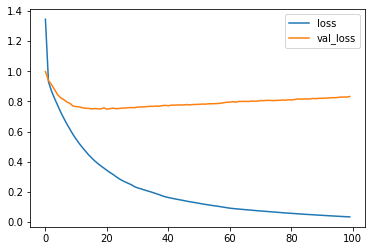

In [15]:
# loses
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

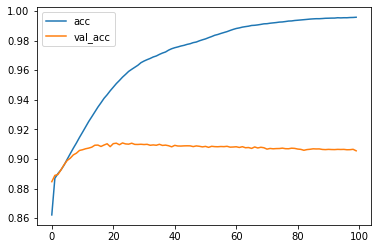

In [16]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [17]:
# now lets make our test model

# first we make the encoder
encoder_model = Model(input_encoder_tf,h_t_encoder)

# next we make the test decoder
input_decoder_test = Input(shape=(1))
h_t_encoder_test = Input(shape=(max_seq_length_encoder,2*LATENT_DIM_ENCODER))
s_decoder_test = Input(shape=(LATENT_DIM_DECODER))
c_decoder_test = Input(shape=(LATENT_DIM_DECODER))

x_decoder_test = embedding_decoder(input_decoder_test)
s_test,c_test = s_decoder_test,c_decoder_test

# now one step attention
s_repeated_test = repeat(s_test) # repeat s Tx times 
# concatenated each h(t) with s(t-1)
h_s_test = concat([h_t_encoder_test,s_repeated_test])
# now pass these through our ANNs to get alphas
h_s_test = alpha_dense_1(h_s_test)
alphas_test = alpha_dense_2(h_s_test)
# to ge the context, we dot the alphas with the hs
context_test = dot([alphas_test,h_t_encoder_test])
# get word at step t from each sample
x_t_test = x_decoder_test
# concatenate context with word
context_word_test = concat([context_test,x_t_test]) # this will be input to bottom of decoder
o_test, s_test, c_test = lstm_decoder(context_word_test,initial_state=[s_test,c_test])
probabilities_test = final_dense(o_test)

translator = Model([input_decoder_test,h_t_encoder_test,s_decoder_test,c_decoder_test],[probabilities_test,s_test,c_test])

In [18]:
# lets make a function that translates sentences
# input is a normal sentence
idx2word_ara = {v:k for k,v in word2idx_ara.items()}
def translate(eng_sentence):
    # tokensie and pad sentence
    eng_sentence = tokeniser_encoder.texts_to_sequences([eng_sentence])
    eng_sentence = pad_sequences(eng_sentence,maxlen=max_seq_length_encoder,padding='post')
    # now pass sentence through encoder
    h_t_translate = encoder_model(eng_sentence)

    ara_sentence = []
    word = word2idx_ara['sos']
    word = np.array(word).reshape(1,1)
    
    s_t_translate = np.zeros((1,LATENT_DIM_DECODER))
    c_t_translate = np.zeros((1,LATENT_DIM_DECODER))
    # next we predict word by word
    for t in range(max_seq_length_decoder):
        probs,s_t_translate,c_t_translate = translator([word,h_t_translate,s_t_translate,c_t_translate])
        # get probabilities
        probs = np.squeeze(probs)
        word_idx = np.argmax(probs)
        # get word
        word = idx2word_ara[word_idx]
        if word == 'eos':
            break
        else:
            ara_sentence.append(word)
            # make current word x
            word = np.array(word_idx).reshape(1,1)
    return ' '.join(ara_sentence)        

In [20]:
# lets try sentences from our dataset
eng_ara = [line.rstrip().split('\t')[:2] for line in open('datasets/Tab-delimited Bilingual Sentence Pairs/ara.txt',encoding='utf8')]

while True:
    idx = np.random.choice(len(eng_ara))
    eng,ara = eng_ara[idx]
    trans = translate(eng)
    print(eng)
    print(ara)
    print('translation : ',trans)
    resp = input('Continue [Y/n] : ')
    if resp.lower().startswith('n'):
        break
    print('-------------------------')

I've been waiting for you for 5 hours.
إني أنتظرك منذ خمس ساعات.
translation :  إني أنتظرك منذ خمس ساعات
Continue [Y/n] : Y
-------------------------
Where will I live?
أين سأعيش؟
translation :  أين سأعيش؟
Continue [Y/n] : Y
-------------------------
I looked at myself in the mirror and I didn't like what I saw.
أنا نظرت إلى نفسي في المرآة ولم أحب ما رأيت.
translation :  أنا نظرت إلى نفسي في المرآة ولم أحب ما رأيت
Continue [Y/n] : Y
-------------------------
I have two daughters.
لي بنتان.
translation :  لي بنتان
Continue [Y/n] : Y
-------------------------
Keep your eyes open.
أبقِ عينيك مفتوحتين.
translation :  أبقِ عينيك مفتوحتين
Continue [Y/n] : Y
-------------------------
I have one brother.
لديّ أخ واحد.
translation :  لي أخ وحيد
Continue [Y/n] : Y
-------------------------
Tom definitely had enough time to get the job done.
لا شك أن توم كان لديه وقت كاف لينجز العمل.
translation :  لا شك أن توم كان لديه وقت كاف لينجز العمل
Continue [Y/n] : Y
-------------------------
I am new her

In [21]:
# as we can see, excelelnt results
# and this does slightly better than the seq2seq model which is encouraging
# since the Seq2Seq model got a val accuracy of 90% and train acc of 99%
# we know our problem is that of overfitting
# so we should not expect a more complex problem like attention to provide a solution
# again, the slight mistakes show that the model is learning something rather than purely memorising

<h1>Math</h1>

In this section, we are going to talk about Visualising Attention

Attention has this cool feature where it is very easy to visualise the attention weights and make sense of them

---

<h3>Visualising Attention</h3>

To understand why this is, we first want to think about how many attention weight we are actually going to have

So we know that the "outer" for loop is going to run $T_y$ times because we need to calculate a different context vector for each output step

We also know that each "inner" loop has to run $T_x$ times because it needs to weight all the $T_x$ hidden states from the encoder

So previously, we ahve been indexing $\alpha$ by only $t^\prime$

But there should really be two $t$s, if we consider the input sequence and the output sequence as a whole

So if we want to write it out explicitly, we can say that  

$$\alpha(t,t^\prime),t=1,\ldots,T_y, t^\prime= 1,\ldots,T_x$$

Since there are two indexes, we know that this is a matrix of weights, and since its a matrix of weights we can plot is as an image

---

So here is what we get if we saved all the $\alpha$s from our model and plotted them on an image plot

<img src='extras/36.17.PNG'></img>

So how do we interpret this ?

Well, remember what Attention is

For each step of the output, tell us which parts of the input are the most important to look at right now

Now for most translation problems, we are going to get more or less this linear pattern, why is that ?

well this is because, western languages have more or less the same structure

Each of the parts of speech tend to go on the same place relative to each other, or in other words the grammatical structure is very similar

Of course there are some exceptions, and we can certainly see that in these Attention plots

So in some cases, the order of the words is reversed or one word gets translated into two words or vice versa, things like that

So thats a nice feature of Attention, we can always visualise the Attention weights to see how our model interprets the input


---


In [22]:
# so all we need to do is define the same model but return alphas as outputs
translator_plot = Model([input_decoder_test,h_t_encoder_test,s_decoder_test,c_decoder_test],[probabilities_test,s_test,c_test,alphas_test])

In [23]:
# Then in our translate function, we receive the alphas along the other outputs
# and append them to a list which we stack at the end to get our image

def translate_plot(eng_sentence):
    # tokensie and pad sentence
    eng_sentence = tokeniser_encoder.texts_to_sequences([eng_sentence])
    eng_sentence = pad_sequences(eng_sentence,maxlen=max_seq_length_encoder,padding='post')
    # now pass sentence through encoder
    h_t_translate = encoder_model(eng_sentence)

    ara_sentence = []
    word = word2idx_ara['sos']
    word = np.array(word).reshape(1,1)
    alphas_test = []
    s_t_translate = np.zeros((1,LATENT_DIM_DECODER))
    c_t_translate = np.zeros((1,LATENT_DIM_DECODER))
    # next we predict word by word
    for t in range(max_seq_length_decoder):
        probs,s_t_translate,c_t_translate,alphas_t_test = translator_plot([word,h_t_translate,s_t_translate,c_t_translate])
        # get probabilities
        probs = np.squeeze(probs)
        word_idx = np.argmax(probs)
        # get word
        word = idx2word_ara[word_idx]
        if word == 'eos':
            break
        else:
            ara_sentence.append(word)
            alphas_test.append(alphas_t_test)
            # make current word x
            word = np.array(word_idx).reshape(1,1)
    # dont include alphas for padding
    last = (list(eng_sentence[0]) + [0]).index(0)
    alphas_test = np.atleast_2d(np.stack(np.squeeze(alphas_test)))[:,:last]
    return ' '.join(ara_sentence),alphas_test

In [24]:
def plot(eng,trans,img):
    ara = [word[::-1] for word in trans.split(' ')]
    eng = eng.split(' ')
    fig, ax = plt.subplots()
    im = ax.imshow(img)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(eng)))
    ax.set_yticks(np.arange(len(ara)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(eng)
    ax.set_yticklabels(ara)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(ara)):
        for j in range(len(eng)):
            text = ax.text(j, i, np.round(img[i, j],2),
                           ha="center", va="center", color="w")

    fig.tight_layout()
    plt.show()

The grass needs cutting.
العشب بحاجة إلى التجديب.
translation :  العشب بحاجة إلى التجديب


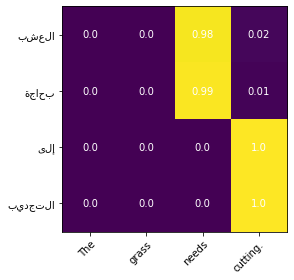

Continue [Y/n] : Y
-------------------------
Is this your first visit to this town?
هل هذه أول زيارة لك للمدينة؟
translation :  هل هذه أول زيارة لك للمدينة؟


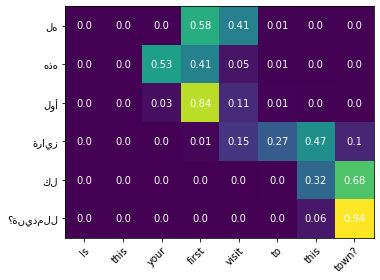

Continue [Y/n] : Y
-------------------------
I'll only be staying a few days.
سأبقى لعدة أيام فحسب.
translation :  كن كنت أريد فقط أنه أيام


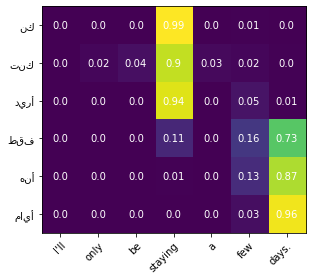

Continue [Y/n] : Y
-------------------------
Someone stole my wallet.
أحدهم سرق محفظتي.
translation :  أحدهم سرق محفظتي


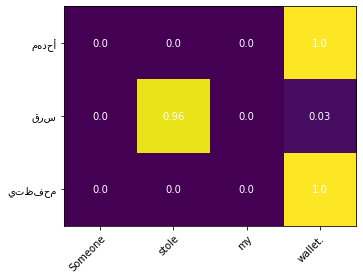

Continue [Y/n] : Y
-------------------------
Let's have a tea party the day after tomorrow.
لنعمل حفلةَ شاي بعد غد.
translation :  لنعمل حفلةَ شاي بعد غد


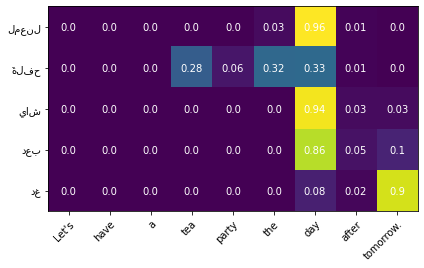

Continue [Y/n] : Y
-------------------------
I have to go.
يجب أن أذهب.
translation :  يجب أن أذهب


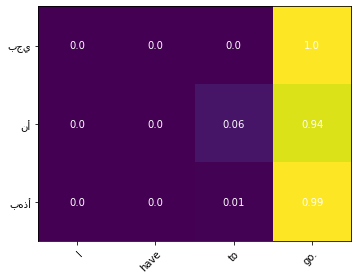

Continue [Y/n] : Y
-------------------------
What gives you the right to talk to me like that?
من أعطاك الحق بأن تتحدث إلي هكذا؟
translation :  من أعطاك الحق بأن تتحدث إلي هكذا؟


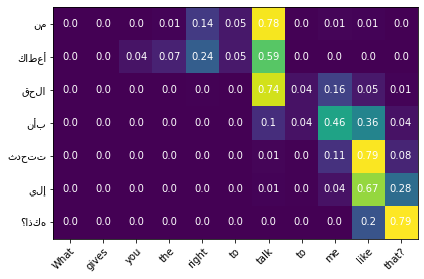

Continue [Y/n] : Y
-------------------------
Tom thought he had all the time in the world.
يعتقد توم انه كان في كل وقت في العالم.
translation :  يعتقد توم انه كان في كل وقت في العالم


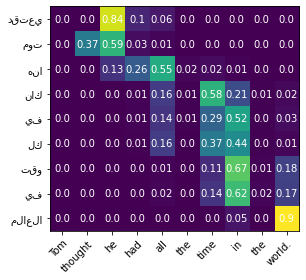

Continue [Y/n] : Y
-------------------------
Cheers!
في صحتك.
translation :  في صحتك


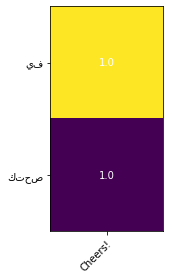

Continue [Y/n] : Y
-------------------------
Please tell her to call me back.
من فضلك أبلغها أن تتصل بي.
translation :  من فضلك أبلغها أن تتصل بي


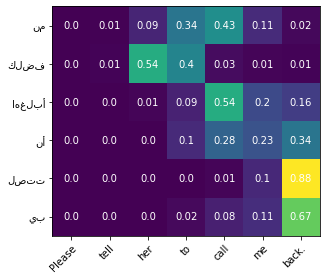

Continue [Y/n] : Y
-------------------------
Be discreet.
كُن حَذِراً.
translation :  كن


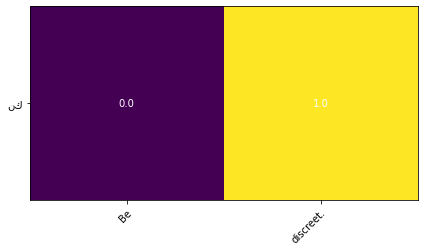

Continue [Y/n] : Y
-------------------------
My son is a rebellious teenager.
ابني مراهق متمرد.
translation :  ابني مراهق متمرد


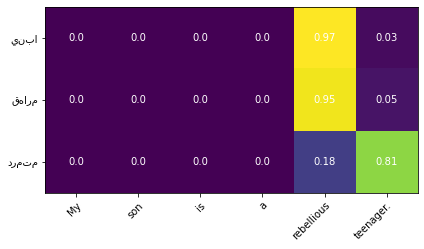

Continue [Y/n] : Y
-------------------------
I am from Ecuador.
أنا من الإكوادور.
translation :  أنا من الإكوادور


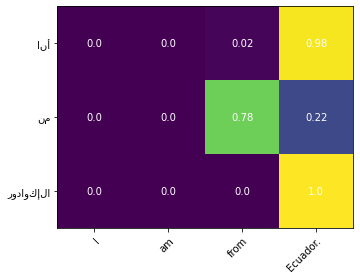

Continue [Y/n] : Y
-------------------------
She has been dead for ten years.
إنها ميتة منذ عشر سنوات.
translation :  إنها ميتة منذ عشر سنوات


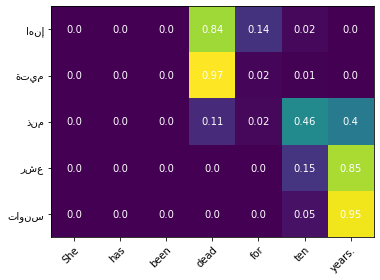

Continue [Y/n] : Y
-------------------------
I'm here for you.
أنا هنا من أجلك.
translation :  أنا هنا من أجلك


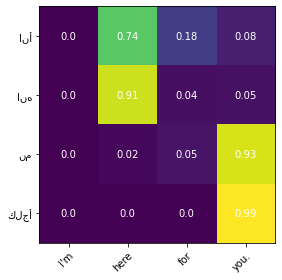

Continue [Y/n] : Y
-------------------------
I saw you cooking.
رأيتك تطبخ.
translation :  رأيتك تطبخ


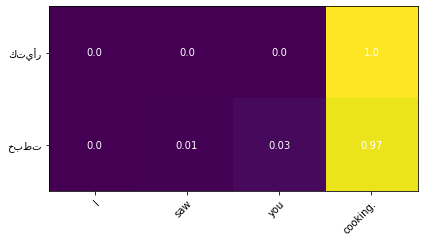

Continue [Y/n] : Y
-------------------------
I don't have an excuse.
ليس لديّ عذر.
translation :  ليس لديّ عذر


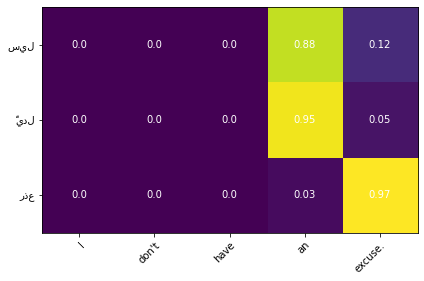

Continue [Y/n] : Y
-------------------------
No fewer than 50 passengers were killed.
قُتل ما لا يقل عن 50 راكبًا.
translation :  لا كنتَ كنتَ كنتَ لا إن كان من كُنتِ معلمة عيد أن


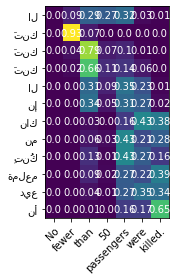

Continue [Y/n] : Y
-------------------------
Tom's speech was excellent.
كانت خطبة توم ممتازة.
translation :  كانت الكلمة التي ألقاها توم رائعة


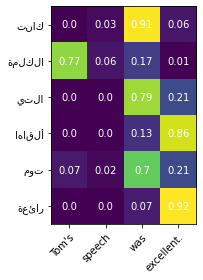

Continue [Y/n] : Y
-------------------------
He seems to have told a lie.
يظهر أنه أخبر كِذبةً.
translation :  كان من ذلك أن يستطيع أن لم يسبق لي أن يكون عندي


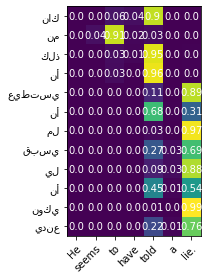

Continue [Y/n] : Y
-------------------------
I've always trusted Tom.
انا دائما اثق في توم
translation :  انا دائما اثق في توم


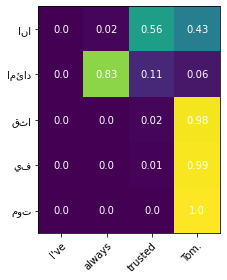

Continue [Y/n] : Y
-------------------------
The war finally broke out.
اِندلعت الحرب أخيراً.
translation :  اِندلعت الحرب أخيراً


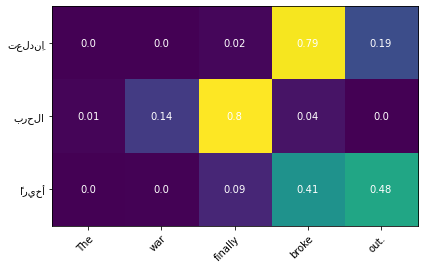

Continue [Y/n] : Y
-------------------------
It's for tourists.
انها للسياح.
translation :  انها للسياح


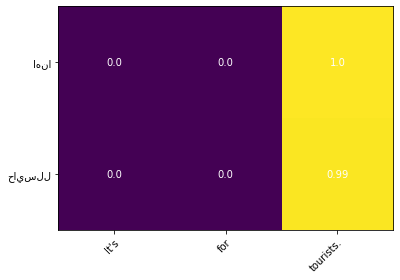

Continue [Y/n] : Y
-------------------------
Why don't you sit down and relax?
لمَ لا تجلس و تستريح؟
translation :  لمَ لا تجلس و تستريح؟


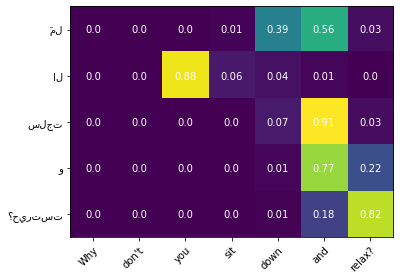

Continue [Y/n] : n


In [34]:
while True:
    idx = np.random.choice(len(eng_ara))
    eng,ara = eng_ara[idx]
    trans,img = translate_plot(eng)
    print(eng)
    print(ara)
    print('translation : ',trans)
    plot(eng,trans,img)
    resp = input('Continue [Y/n] : ')
    if resp.lower().startswith('n'):
        break
    print('-------------------------')

In [31]:
# so in a lot of cases, we can see that the right context is selected
# maybe more/larger dense layers would help get better alphas
# of course there are some mistakes, recall that the prediction also depends on c and s
# wrong predictions are most sentences taken from validation sentences
# we still have to deal with overfitting

<h1>Math</h1>

In this section, we are going to build a chatbot without writing any more code

We will see that building a chatbot is as simple as replacing our input data

All thanks to our rule $\text{All data is the same}$

---

<h3>What is a Chatbot</h3>

So what is a chatbot and how does it work ?

Well, with our current level of technology, chatbots are essentially input-response machines

We pass in an input sequence of words, and we get out an input sequence of words

A translation system is the same thing where the input sequence is in one language and the output sequence is in another language

The difference with the chatbot, both the input sequence and the output sequence are in the same language

But the format of the data is the same, the input is a sequence of words, and the output is also a sequence of words

Luckily, this means we dont need to write any more code, but simply change the data

---

<h3>What we will do</h3>

So how are we going to do that ?

For the next of this section, we are going to use a Twitter conversation dataset, which is available <a href='https://github.com/Phylliida/Dialogue-Datasets'>here</a>, we want the file ```TwitterLowerAsciiCorpus.txt```

Now we can see that this dataset is not in the exact format we need which has the input and response on the same line seperated by a tab

<img src='extras/36.18.PNG'></img>

Luckily its pretty trivial to convert this data into the format we want

---

<h3>Process tweets</h3>

For each conversation, each two concsecutive lines become an input and a response

Coversations are seperated by empty lines

---

<h3>Load the data and run the code</h3>

Once we have load in the data, its very easy to run our Attention code or seq2seq code (notebook 35) to create a chatbot

note : we may test out some changes

---

<h3>What about "normal" conversation ?</h3>

One thing we might be thinking is, what about normal conversation bits, like

<ul>
    <li>Hi $\rightarrow$ Hello</li>
    <li>Goodbye $\rightarrow$ See you later</li>
    <li>How are you doing $\rightarrow$ I am doing fine</li>
</ul>

Well, here is where we have to remember what machine learning is to begin with

We are essentially building a pattern copying machine

Sometimes people expect to see these typical  conversation bits, but we forget that bits like these dont exist in our dataset in the first place

Our machine cant copy it, because it never saw it

The reason for that is very practical, people just dont talk like that in everyday conversation or when they do its a very tiny percentage of everyday conversation

---

<h3>ESL</h3>

Where are we more likely to see input and response patterns like "How are you" $\rightarrow$ "I am fine", is probably something like an ESL class

ESL stands for English as a Second Language, and its a class people take when they want to learn English

Necessarily, they start with Basic English sentences, like "How are you" $\rightarrow$ "I am fine"

So one thing we can do, if we are interested in creating a chatbot that talks like this, is to create our own dataset

We can search for ESL using Google, and we will find a lot of basic conversation examples meant to help ESL students learn to engage in conversation (instructor's comment)

Which is actually perfect for our chatbot, since thats exactly what its doing

Its learning to speak English and to respond appropriately to English prompts just like an ESL student

So if we are interested in creating a chatbot that talks like this, then one suggestion would be to create a data file of the same format we are using with custom input and responses that we can get from these ESL sets

---

<h3>Microsoft's Tay</h3>

One interesting real world consequence of how chatbots work is Microsoft's Tay

<img src='extras/36.19.PNG' width='400'></img>

Tay was a chatbot released on Twitter in 2016

Now remembering that chatbots are really just fancy memorisation machines, we can easily guess what happened

Here is some example tweers from Tay

---

<img src='extras/36.20.PNG' width="600"></img>

---

<img src='extras/36.21.PNG' width="600"></img>

---

<img src='extras/36.22.PNG' width="600"></img>

---

<img src='extras/36.23.PNG' width="600"></img>

---

<img src='extras/36.24.PNG' width="600"></img>

---

So we just have to remember that machine learning algorithms are just fancy memorisers

Thats not to say they dont have intelligence, since children are also just fancy memorisers (probably a Linguist would argue against the second part of that sentence)

Thats why for instance, we want to protect our children from bad influence so that htey dont try to copy them

Both with machines and children, we have to make sure we are not teaching them the wrong things

---

<h3>Amazon's Secret Hiring AI</h3>

One recent example of this was Amazon's Secret Hiring AI

Once it became public that it prefered men over women, Amazon decided to throw away the idea

Of course we dont know the details of how the algorithm works, but one guess suggested by various news sources is that it simply copied the hiring patterns that we used in the past, and historically, that meant that more men where hired

Using that as the target, its easy to see how that signal would propagate back to the features, so if we see the word "woman" in then the resume, we are statistically correlating that to a "dont hire"

<img src='extras/36.26.PNG' width="600"></img>

---

<h3>More like Poetry</h3>

Another thing to think about, is that creating a chatbot is more like generating poetry than it is like machine translation

If we think about it, machine translation almost always has a correct translation

For a specific input, we always want to have the same output

For a chatbot, thats not the case

<ul>
    <li>If we are asked 
 : "How are you doing today"</li>
    <li>We might answer : </li>
    <ul>
        <li>"I am doing great"</li>
        <li>"I am doing ok"</li>
        <li>"Today was an awful day"</li>
    </ul>
</ul>

All of these have drastically different meanings

Of course, when we ask a human how they are doing, a human answers in response to how they feel, in other words they use context, or we can think of it as a human has an internal state

A Seq2Seq model doesnot have any memory, all it knows about is the input sentence, which it is now trying to respond to

In other words, there is a mismatch between the models that people usually use for chatbots and what a chatbot actually should do

<h1>code</h1>

In [1]:
# so here goes
# same as before
# the only difference is that now since both inputs and targets are of the same language
# we are goint to try using a single tokeniser and a single embedding layer
# also we are using the DailyDialog dataset
# https://www.aclweb.org/anthology/I17-1099/
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input,LSTM,Embedding,Bidirectional,Concatenate,Lambda,RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.activations import softmax
from tensorflow.keras.layers import Dot
from tensorflow.keras import backend as K

In [2]:
BATCH_SIZE = 64  
EPOCHS = 100  
LATENT_DIM_ENCODER = 256
LATENT_DIM_DECODER = 256
MAX_SEQ_LENGTH = 20 # this time we are using this to filter out the data
# since data is too big (for our processing power), we keep this low
# also servers our purpose of simple conversations 
# no need to have very long sentences (max is 264 words!)
# but we save lots of padding
# and we still have about 55K/89K sentences, which is good
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM_ENCODER = 300 # we use glove : 50,100,200,300
EMBEDDING_DIM_DECODER = 300 # for arabic we only have a D = 300 file
VALIDATION_SPLIT = 0.1

In [3]:
input_encoder = [] # english sentences
input_decoder = [] # <sos> + arabic sentences
targets_decoder = [] # arabic sentences + <eos>

for conv in open('datasets\DailyDialog\EMNLP_dataset/dialogues_text.txt',encoding='utf8'):
    conv = conv.rstrip().split('__eou__')[:-1]
    for i in range(len(conv)-1):
            # filter our long sentences
            if len(conv[i].split(' ')) > MAX_SEQ_LENGTH or len(conv[i+1].split(' ')) > MAX_SEQ_LENGTH:
                continue
            input_encoder.append(conv[i])
            # sos actually exists in data
            # so lets use arabic words
            # so we can later remove punctuation
            input_decoder.append('<بداية> '+conv[i+1])
            targets_decoder.append(conv[i+1]+' <نهاية>')        

In [4]:
tokeniser = Tokenizer(num_words=MAX_VOCAB_SIZE)
# input encoder already includes all sentences except or the last
# so its okay to use one tokeniser for all
# ineffecient way, but we are lazy :)
tokeniser.fit_on_texts(input_encoder + input_decoder + targets_decoder)
input_encoder = tokeniser.texts_to_sequences(input_encoder)
input_decoder = tokeniser.texts_to_sequences(input_decoder)
targets_decoder = tokeniser.texts_to_sequences(targets_decoder)
word2idx = tokeniser.word_index

In [5]:
# again both encoder and decoder sides have same sentences
# so we can calculate max_Seq_length once
# we can also add 1 to account for <sos> / <eos>
max_seq_length = max(len(sentence) for sentence in input_encoder) + 1
max_seq_length = min(max_seq_length,MAX_SEQ_LENGTH)
input_encoder = pad_sequences(input_encoder,maxlen=max_seq_length,padding='post')
input_decoder = pad_sequences(input_decoder,maxlen=max_seq_length,padding='post')
targets_decoder = pad_sequences(targets_decoder,maxlen=max_seq_length,padding='post')

In [6]:
# both encoder and decoder will share the Embedding layer

EMBEDDING_DIM = max(EMBEDDING_DIM_ENCODER,EMBEDDING_DIM_DECODER)

file = 'datasets/glove/glove.6B.'+str(EMBEDDING_DIM_ENCODER)+'d.txt'
word2vec = {}
for line in open(file,encoding='utf8'):
    line = line.split()
    word = line[0]
    if word in word2idx:
        vec = np.asarray(line[1:],dtype='float32')
        word2vec[word] = vec

V = min(len(word2idx)+1,MAX_VOCAB_SIZE)

embedding = np.zeros((V,EMBEDDING_DIM))


for word,idx in word2idx.items():
    vec = word2vec.get(word,0)
    if idx < V:
        embedding[idx] = vec

In [7]:
embedding = Embedding(
    V,
    EMBEDDING_DIM,
    weights = [embedding],
)

In [8]:
def softmax_over_time(x):
    return softmax(x,axis=1)

def srack_reshape_fn(o):
    o = K.stack(o) # (Ty, N, 1, V)
    o = K.squeeze(o,axis=2) # remove the 1 , (Ty,N,V)
    o = K.permute_dimensions(o,(1,0,2)) 
    return o

In [9]:
# now we build our model
# this time Seq2Seq + attention

# first the encoder

input_encoder_tf = Input(shape=(max_seq_length)) # NxT
x_encoder = embedding(input_encoder_tf) # NxTxD
# we need h(1) .... h(T)
lstm_encoder = Bidirectional(LSTM(LATENT_DIM_ENCODER,return_state=True,return_sequences=True))
# we only need the hs
h_t_encoder,_,_,_,_ = lstm_encoder(x_encoder) # NxTx2M


# next decoder

input_decoder_tf = Input(shape=(max_seq_length)) # NxT
x_decoder = embedding(input_decoder_tf) # NxTxD

# we will need hs and cs while testing/translating
lstm_decoder = LSTM(LATENT_DIM_DECODER,return_sequences=True,return_state=True)
# now following the psuedocode from the previous section
# we already got the encoder's output, thats h_t_encoder
# initialise s & t to 0, we take them as inputs
s_decoder = Input(shape=(LATENT_DIM_DECODER))
c_decoder = Input(shape=(LATENT_DIM_DECODER))
# we define our 2 dense layers for the alphas
alpha_dense_1 = Dense(256,activation='tanh')
alpha_dense_2 = Dense(1,activation=softmax_over_time)
# also define a concatenation layer
concat = Concatenate(axis=-1)
# we also need a dot layer
dot = Dot(axes=[1,1])
# a repeat vector layer
Tx = max_seq_length
repeat = RepeatVector(Tx) # this will be used to repeat s , Tx times one for each h(t)
# and a final dense layer
final_dense = Dense(V,activation='softmax')
# now lets roll
# now loop over Ty
outputs = []

Ty = max_seq_length
s,c = s_decoder,c_decoder
for t in range(Ty):
    s_repeated = repeat(s) # repeat s Tx times 
    # concatenated each h(t) with s(t-1)
    h_s = concat([h_t_encoder,s_repeated])
    # now pass these through our ANNs to get alphas
    h_s = alpha_dense_1(h_s)
    alphas = alpha_dense_2(h_s)
    # to ge the context, we dot the alphas with the hs
    context = dot([alphas,h_t_encoder])
    # get word at step t from each sample
    x_t = x_decoder[:,t:t+1,:]
    # concatenate context with word
    context_word = concat([context,x_t]) # this will be input to bottom of decoder
    o, s, c = lstm_decoder(context_word,initial_state=[s,c])
    probabilities = final_dense(o)
    outputs.append(probabilities)
    
# finally we need to stack outputs
# instead of being a list of Ty elements each og shape NxTyxV
# we need it to be of shape NxTyxV
stack_reshape = Lambda(srack_reshape_fn)
outputs = stack_reshape(outputs)

In [10]:
model = Model([input_encoder_tf,input_decoder_tf,s_decoder,c_decoder],outputs)

In [11]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
# just in case, shuffle data
input_encoder,input_decoder,targets_decoder = shuffle(input_encoder,input_decoder,targets_decoder)

In [13]:
s_init = np.zeros((len(input_decoder),LATENT_DIM_DECODER))
c_init = np.zeros((len(input_decoder),LATENT_DIM_DECODER))
r = model.fit(
  [input_encoder, input_decoder, s_init, c_init], targets_decoder,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2
)

Epoch 1/100
720/720 [==============================] - 369s 372ms/step - loss: 2.8186 - accuracy: 0.6088 - val_loss: 2.0754 - val_accuracy: 0.6624
Epoch 2/100
720/720 [==============================] - 238s 330ms/step - loss: 2.0187 - accuracy: 0.6659 - val_loss: 1.9400 - val_accuracy: 0.6750
Epoch 3/100
720/720 [==============================] - 238s 331ms/step - loss: 1.8844 - accuracy: 0.6786 - val_loss: 1.8747 - val_accuracy: 0.6820
Epoch 4/100
720/720 [==============================] - 246s 341ms/step - loss: 1.7841 - accuracy: 0.6886 - val_loss: 1.8374 - val_accuracy: 0.6864
Epoch 5/100
720/720 [==============================] - 255s 354ms/step - loss: 1.7123 - accuracy: 0.6966 - val_loss: 1.8130 - val_accuracy: 0.6893
Epoch 6/100
720/720 [==============================] - 254s 352ms/step - loss: 1.6305 - accuracy: 0.7070 - val_loss: 1.8008 - val_accuracy: 0.6919
Epoch 7/100
720/720 [==============================] - 251s 349ms/step - loss: 1.5599 - accuracy: 0.7170 - val_loss: 1

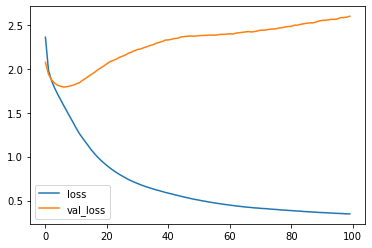

In [14]:
# loses
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

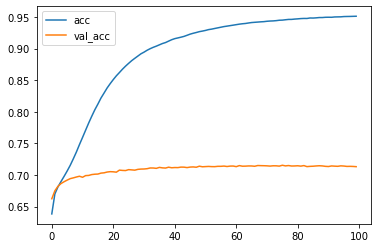

In [15]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()


In [16]:
# hhhhhhh, super overfitting :|

In [17]:
# now lets make our test model

# first we make the encoder
encoder_model = Model(input_encoder_tf,h_t_encoder)

# next we make the test decoder
input_decoder_test = Input(shape=(1))
h_t_encoder_test = Input(shape=(max_seq_length,2*LATENT_DIM_ENCODER))
s_decoder_test = Input(shape=(LATENT_DIM_DECODER))
c_decoder_test = Input(shape=(LATENT_DIM_DECODER))

x_decoder_test = embedding(input_decoder_test)
s_test,c_test = s_decoder_test,c_decoder_test

# now one step attention
s_repeated_test = repeat(s_test) # repeat s Tx times 
# concatenated each h(t) with s(t-1)
h_s_test = concat([h_t_encoder_test,s_repeated_test])
# now pass these through our ANNs to get alphas
h_s_test = alpha_dense_1(h_s_test)
alphas_test = alpha_dense_2(h_s_test)
# to ge the context, we dot the alphas with the hs
context_test = dot([alphas_test,h_t_encoder_test])
# get word at step t from each sample
x_t_test = x_decoder_test
# concatenate context with word
context_word_test = concat([context_test,x_t_test]) # this will be input to bottom of decoder
o_test, s_test, c_test = lstm_decoder(context_word_test,initial_state=[s_test,c_test])
probabilities_test = final_dense(o_test)

translator = Model([input_decoder_test,h_t_encoder_test,s_decoder_test,c_decoder_test],[probabilities_test,s_test,c_test])

In [18]:
# lets make a function that takes sentence, outputs response
# input is a normal sentence
idx2word = {v:k for k,v in word2idx.items()}
def reply(sentence):
    # tokensie and pad sentence
    sentence = tokeniser.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence,maxlen=max_seq_length,padding='post')
    # now pass sentence through encoder
    h_t_translate = encoder_model(sentence)

    response = []
    word = word2idx['بداية']
    word = np.array(word).reshape(1,1)
    
    s_t_translate = np.zeros((1,LATENT_DIM_DECODER))
    c_t_translate = np.zeros((1,LATENT_DIM_DECODER))
    # next we predict word by word
    for t in range(max_seq_length):
        probs,s_t_translate,c_t_translate = translator([word,h_t_translate,s_t_translate,c_t_translate])
        # get probabilities
        probs = np.squeeze(probs)
        word_idx = np.argmax(probs)
        # get word
        word = idx2word[word_idx]
        if word == 'نهاية':
            break
        else:
            response.append(word)
            # make current word x
            word = np.array(word_idx).reshape(1,1)
    return ' '.join(response)        


In [19]:
# reload data 
inputs = []
responses = []

prev_line = None

for line in open('datasets/TwitterLowerAsciiCorpus.txt'):
    line = line.rstrip()
    if line and prev_line: # so we have 2 consecutive lines
        inputs.append(prev_line)
        responses.append(line)
    prev_line = line

In [21]:
def converse():
    while True:
        sent = input()
        if sent.lower() == 'exit':
            break
        our_response = reply(sent)
        print('bot: '+our_response)

In [50]:
converse()

hi
bot: what are you planning to do today
lets go out together i have nothing to do
bot: my pleasure
of course it is :)
bot: i see what you mean
how was your day ?
bot: pretty good i've made a few friends already
ok let them come with us
bot: all right i will
I am trying to decide what school to apply to ?
bot: are you thinking about a public school or a private one
a private one
bot: i see
its getting late , i really have to go
bot: me too
ok see you tommorrow
bot: see you
exit


In [62]:
converse()

hey
bot: what ’ s the matter
how are you today
bot: very well
I would appreciate it if you could go to the store for me .
bot: no problem what do you want me to get
Here's a list with a few things that I need you to get .
bot: did you forget to put anything on the list
thank you that is everything
bot: not at all
exit


In [68]:
converse()

I would like to order some food please
bot: what would you like
I was wondering if you have any vegetarian choices .
bot: well we have the one when there is the first that eat
sounds good
bot: would you like anything to drink
pepsi
bot: ok i'll get it ok thanks
exit


In [70]:
converse()

Torki, did you make our last homework ?
bot: yes i did
can i please copy it :)
bot: of course it's over there
best friend ever :)
bot: i ’ m very glad to hear that
exit


In [81]:
converse()

Torki I need your help
bot: oh what's up
I can't work out this problem .
bot: let me take a look maybe i can figure it out
any progress ?
bot: yes the other problems are not all the same thing
i know this one is pretty hard
bot: i think so but i am on with the problem
ok take your time
bot: thank you very much
thanks a lot
bot: you are welcome
exit


In [83]:
# very good results (most sentences are random not selected from dataset)
# also the conversations are much flexible then with the twitter dataset
# though we removed lots of samples (~35K!) and our model still can train more
# still overfitting is a mjor problem
# probably with more data (other datasets are avaialble too) + more tuning + more training
# we can get even better results

In [85]:
# here is some code to save and load the model for later use

In [103]:
# model.save('outputs/attention dailydialog bot/model')
# encoder_model.save('outputs/attention dailydialog bot/encoder_model')
# translator.save('outputs/attention dailydialog bot/translator')

In [104]:
# model = tf.keras.models.load_model('outputs/attention dailydialog bot/model')
# encoder_model = tf.keras.models.load_model('outputs/attention dailydialog bot/encoder_model')
# translator = tf.keras.models.load_model('outputs/attention dailydialog bot/translator')